In [63]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# Useful Functions

The following fucntions are being created so that they can be called later one without having to create them everytime. 


In [64]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_model(X,y, model, show_figures=True): 
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_figures:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()

## Data reading and preparation

The dataset is offered in two separated fields, one for the training and another one for the test set. Both the datasets are first laoded. 

In [65]:
import pandas as pd

training = pd.read_csv("Absenteeism_at_work_classification_training.csv", delimiter=";", decimal=".")
test = pd.read_csv("Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

In [66]:
test['Absenteeism'] = 0
dataset = training.append(test)

Let's now visualize the dataset to see where to begin.

In [67]:
pd.options.display.max_columns = dataset.shape[1] # It prints the info in all the columns

dataset.describe()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,370.500000,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,18.017568,0.294595
std,213.763888,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,11.021247,0.456169
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000,0.000000
25%,185.750000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,9.000000,0.000000
50%,370.500000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,18.000000,0.000000
75%,555.250000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,28.000000,1.000000
max,740.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,36.000000,1.000000


## Data Cleaning. 


### Changing data from numerical to categorical

In [68]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

To facilitate the understanding of the feature analysis, we change the name of some of them to their actual meaning (this meaning is in the dataset description file).

In [69]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')
dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')
dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')

### Creating the dummified dataset
Finally, since we have numerical and categorical values, we have to dummify the categorical features in the dataset so we can train our ML models. I will also standardize the numerical values

In [70]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable

# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)
dummified_dataset.head(5)

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height,Body.mass.index,...,Disciplinary.failure_0,Disciplinary.failure_1,Education_graduate,Education_highschool,Education_master&PhD,Education_postgraduate,Social.drinker_0,Social.drinker_1,Social.smoker_0,Social.smoker_1,Absenteeism
0,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.578947,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,0.000000,0.170213,0.607143,0.741935,0.194471,0.842105,0.25,0.000,0.807692,0.454545,0.631579,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,0.225926,0.978723,0.607143,0.354839,0.194471,0.842105,0.00,0.000,0.634615,0.212121,0.631579,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,0.596296,0.000000,0.464286,0.387097,0.194471,0.842105,0.50,0.000,0.230769,0.151515,0.263158,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.578947,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


### Removing Outliers

In [71]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    print("{} outliers removed".format(len(df_in)-len(df_out)))
    return df_out

dummified_dataset = remove_outlier(dummified_dataset,'Transportation.expense')
dummified_dataset = remove_outlier(dummified_dataset,'Service.time')
dummified_dataset = remove_outlier(dummified_dataset,'Work.load.Average.day')
dummified_dataset = remove_outlier(dummified_dataset,'Height')
dummified_dataset = remove_outlier(dummified_dataset,'Pet')

3 outliers removed
5 outliers removed
30 outliers removed
107 outliers removed
29 outliers removed


### Developing a baseline model.

Accuracy = 0.7491


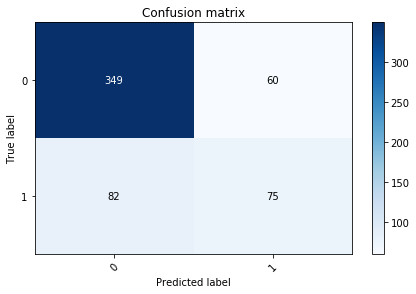

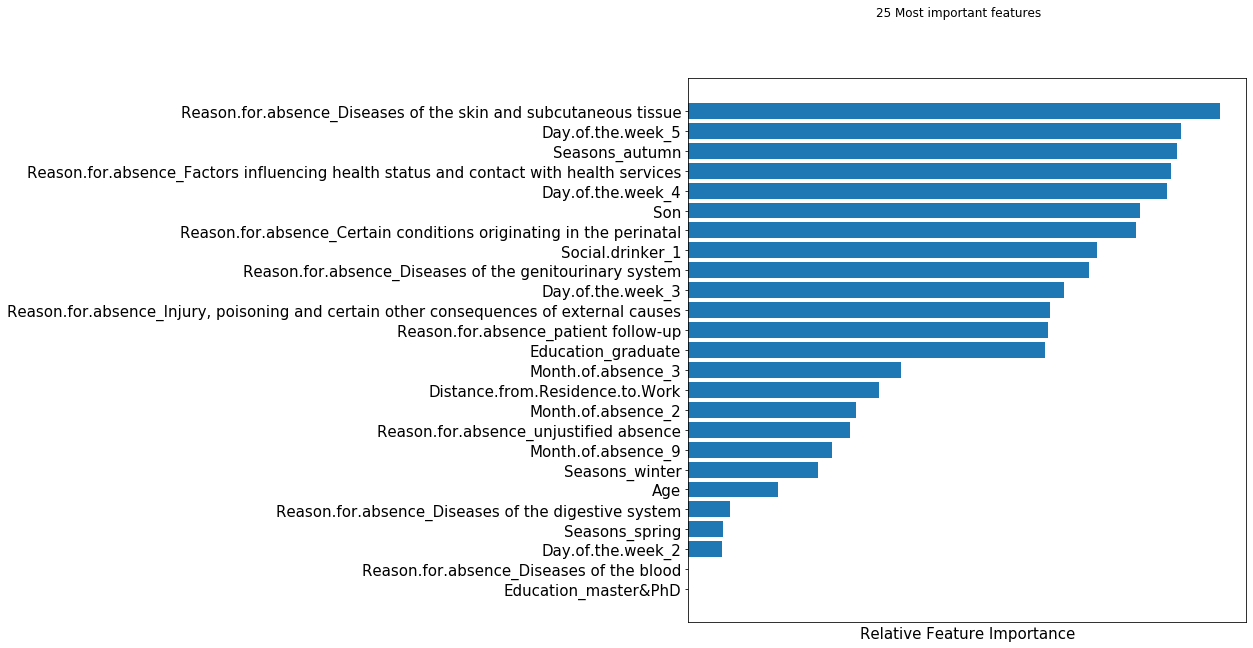

In [72]:
baseline_model, score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'))

### Feature Creation & Splitting Test-Train datasets. 

In [73]:
from sklearn.model_selection import train_test_split

# 'Absenteeism' is the target variable
X = dummified_dataset.loc[:, dummified_dataset.columns != 'Absenteeism']
y = dummified_dataset['Absenteeism']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [75]:
from sklearn import linear_model
initial_lm_mod = linear_model.LogisticRegression(max_iter=1000, penalty='none')
initial_lm_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy = 0.8289


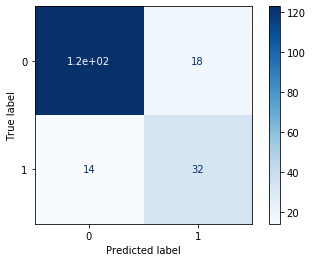

In [76]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))
plot_confusion_matrix(initial_lm_mod, X_test, y_test, y_test.unique(), cmap=plt.cm.Blues)


In [77]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', accuracy_score(y_test,initial_lm_mod.predict(X_test))]
results_df

,Approach,Accuracy
0,LR Baseline,0.828877


In [78]:
# Train the model using all the data
final_model = initial_lm_mod

In [79]:
# Test prediction
final_pred = final_model.predict(X_test)

In [80]:
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({'ID':X_test.index, 'Absenteeism.time.in.hours':final_pred})

In [81]:
predictions.to_csv("predictions.csv", index=False)

In [82]:
print("Accuracy = {0:.4f}".format(accuracy_score(y_test,initial_lm_mod.predict(X_test))))

Accuracy = 0.8289


### The End